In [17]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

Carga do Dataset

In [2]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/fhcavalcante/datasets/main/stroke-data-s.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=';')

# Mostra as primeiras linhas do dataset
dataset.head()

,age,ht,hd,glucose,bmi,outcome
0,67.0,0,1,228.69,36.6,1
1,61.0,0,0,202.21,0.0,1
2,80.0,0,1,105.92,32.5,1
3,49.0,0,0,171.23,34.4,1
4,79.0,1,0,174.12,24.0,1


Separação de treino e Holdout

In [3]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:5]
y = array[:,5]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

Criação e avaliação dos modelos: linha base

KNN: 0.944963 (0.005796)
CART: 0.915844 (0.009799)
NB: 0.878423 (0.015440)


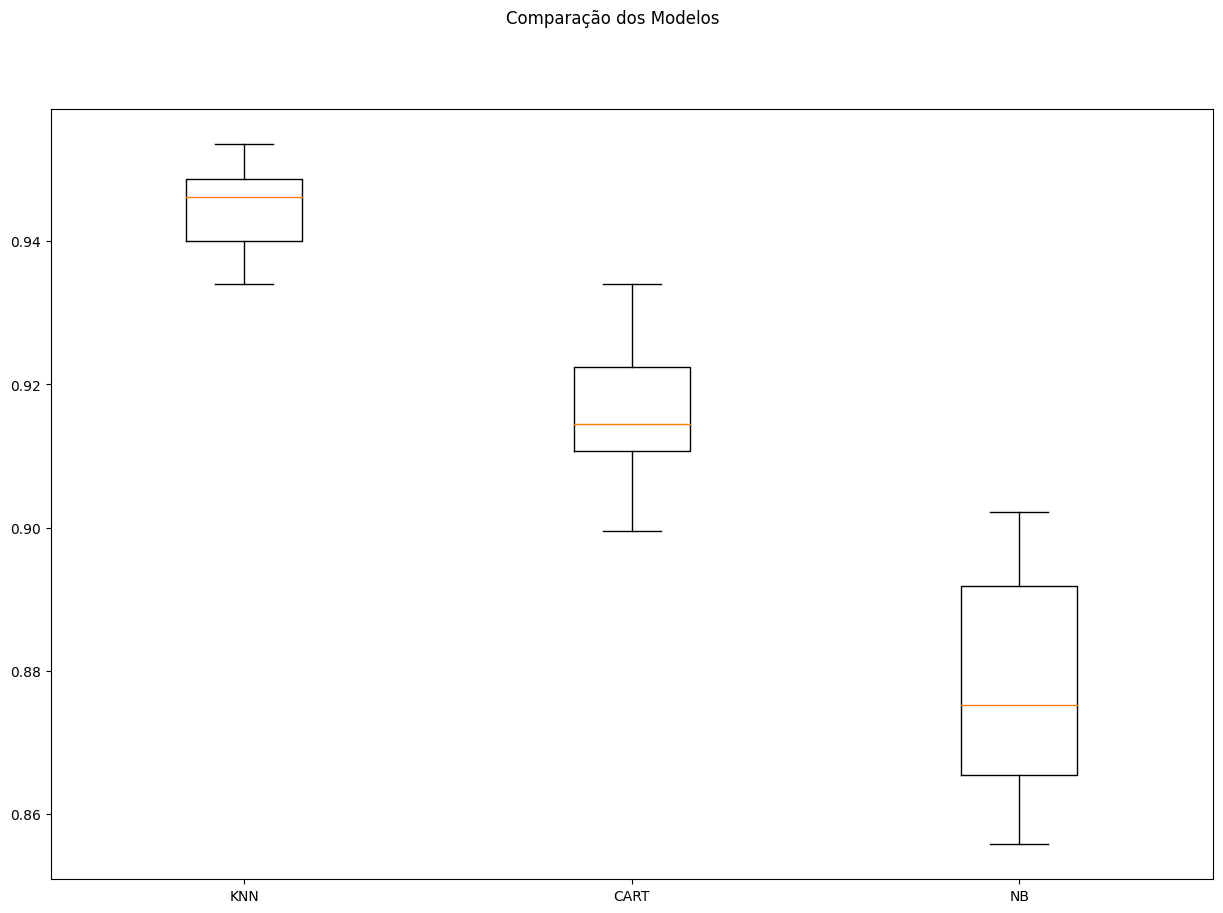

In [5]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))


# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.945 (0.006)
CART-orig: 0.916 (0.010)
NB-orig: 0.878 (0.015)
KNN-padr: 0.948 (0.005)
CART-padr: 0.916 (0.008)
NB-padr: 0.878 (0.015)
KNN-norm: 0.944 (0.006)
CART-norm: 0.913 (0.010)
NB-norm: 0.878 (0.015)


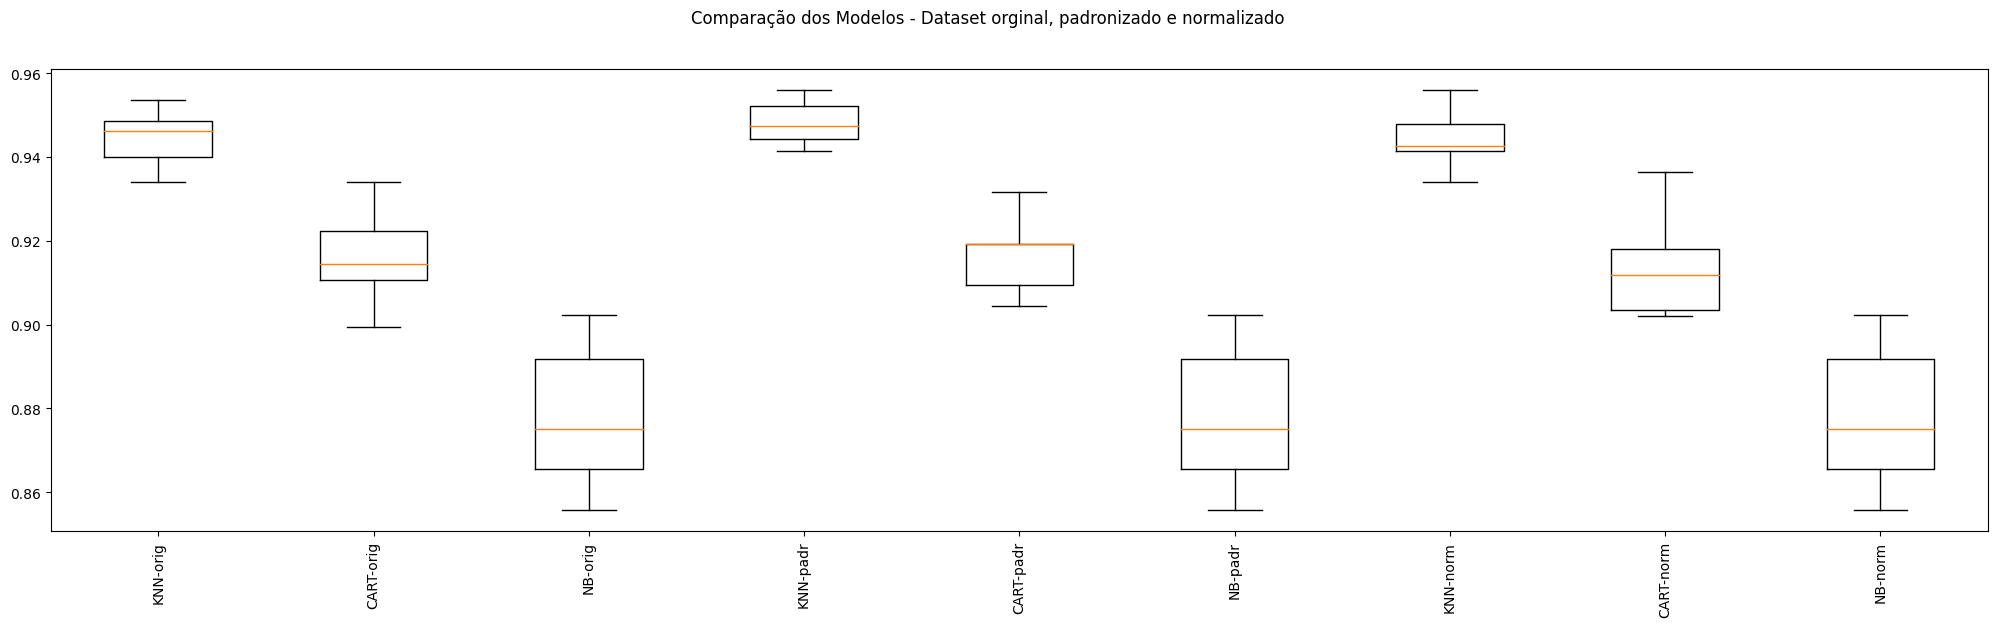

In [6]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

Otimização dos hiperparâmetros

In [7]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: knn-orig - Melhor: 0.951321 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 21}
Sem tratamento de missings: knn-padr - Melhor: 0.951566 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 19}
Sem tratamento de missings: knn-norm - Melhor: 0.951322 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 11}


In [ ]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                ('KNN', KNeighborsClassifier())])

Simulando o modelo em dados não vistos

In [15]:
# Dados novos, não sabemos a classe

data = {'age': [67,68,69],
        'ht': [1,1,1],
        'hd': [0,1,0],
        'glucose': [167,268,169],
        'bmi': [24,32,36]
        }
atributos = ['age','ht','hd','glucose','bmi']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:5].astype(float)

# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model = model.fit(rescaledX, y)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[ 1.05143428  3.04319637 -0.2389468   1.34393757 -0.39425999]
 [ 1.09566165  3.04319637  4.18503199  3.57454585  0.4453208 ]
 [ 1.13988902  3.04319637 -0.2389468   1.38810804  0.8651112 ]]


In [16]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[0. 1. 0.]


Salvando os arquivos

In [18]:
# Salvar o classificador KNN
filename = 'knnNorm_classifierv2.pkl'
pickle.dump(grid.best_estimator_, open(filename, 'wb'))
from google.colab import files
files.download(filename)

# Salvar o StandardScaler
filename = 'knnNorm_scaler.pkl'
pickle.dump(standard_scaler, open(filename, 'wb'))
files.download(filename)

# Salvar o pipeline
filename = 'knnNorm_pipeline.pkl'
pickle.dump(pipelines[1], open(filename, 'wb'))
files.download(filename)

# Salvar o dataset de treino
filename = 'X_train_knnNorm.pkl'
pickle.dump(X_train, open(filename, 'wb'))
files.download(filename)

filename = 'y_train_knnNorm.pkl'
pickle.dump(y_train, open(filename, 'wb'))
files.download(filename)

# Salvar o dataset de teste
filename = 'X_test_knnNorm.pkl'
pickle.dump(X_test, open(filename, 'wb'))
files.download(filename)

filename = 'y_test_knnNorm.pkl'
pickle.dump(y_test, open(filename, 'wb'))
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>